### Importing land cover dataset and libraries

In [5]:
from PIL import Image
import numpy as np
image = Image.open('/content/exportedImage.tif')
import tensorflow as tf
image_tf=tf.constant(image)
import matplotlib.pyplot as plt
import torch
import cv2

In [6]:
def display_image(image, title='Image', cmap='gray'):
    

    if torch.is_tensor(image):
        image_np = image.numpy()
    elif isinstance(image, np.ndarray):
        image_np = image
    else:
        raise TypeError("The image must be a PyTorch tensor or a NumPy array.")

    if image_np.max() > 1:
        image_np = image_np / 255.0

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np, cmap=cmap)
    plt.title(title)
    plt.axis('off')  
    plt.show()


### Land cover

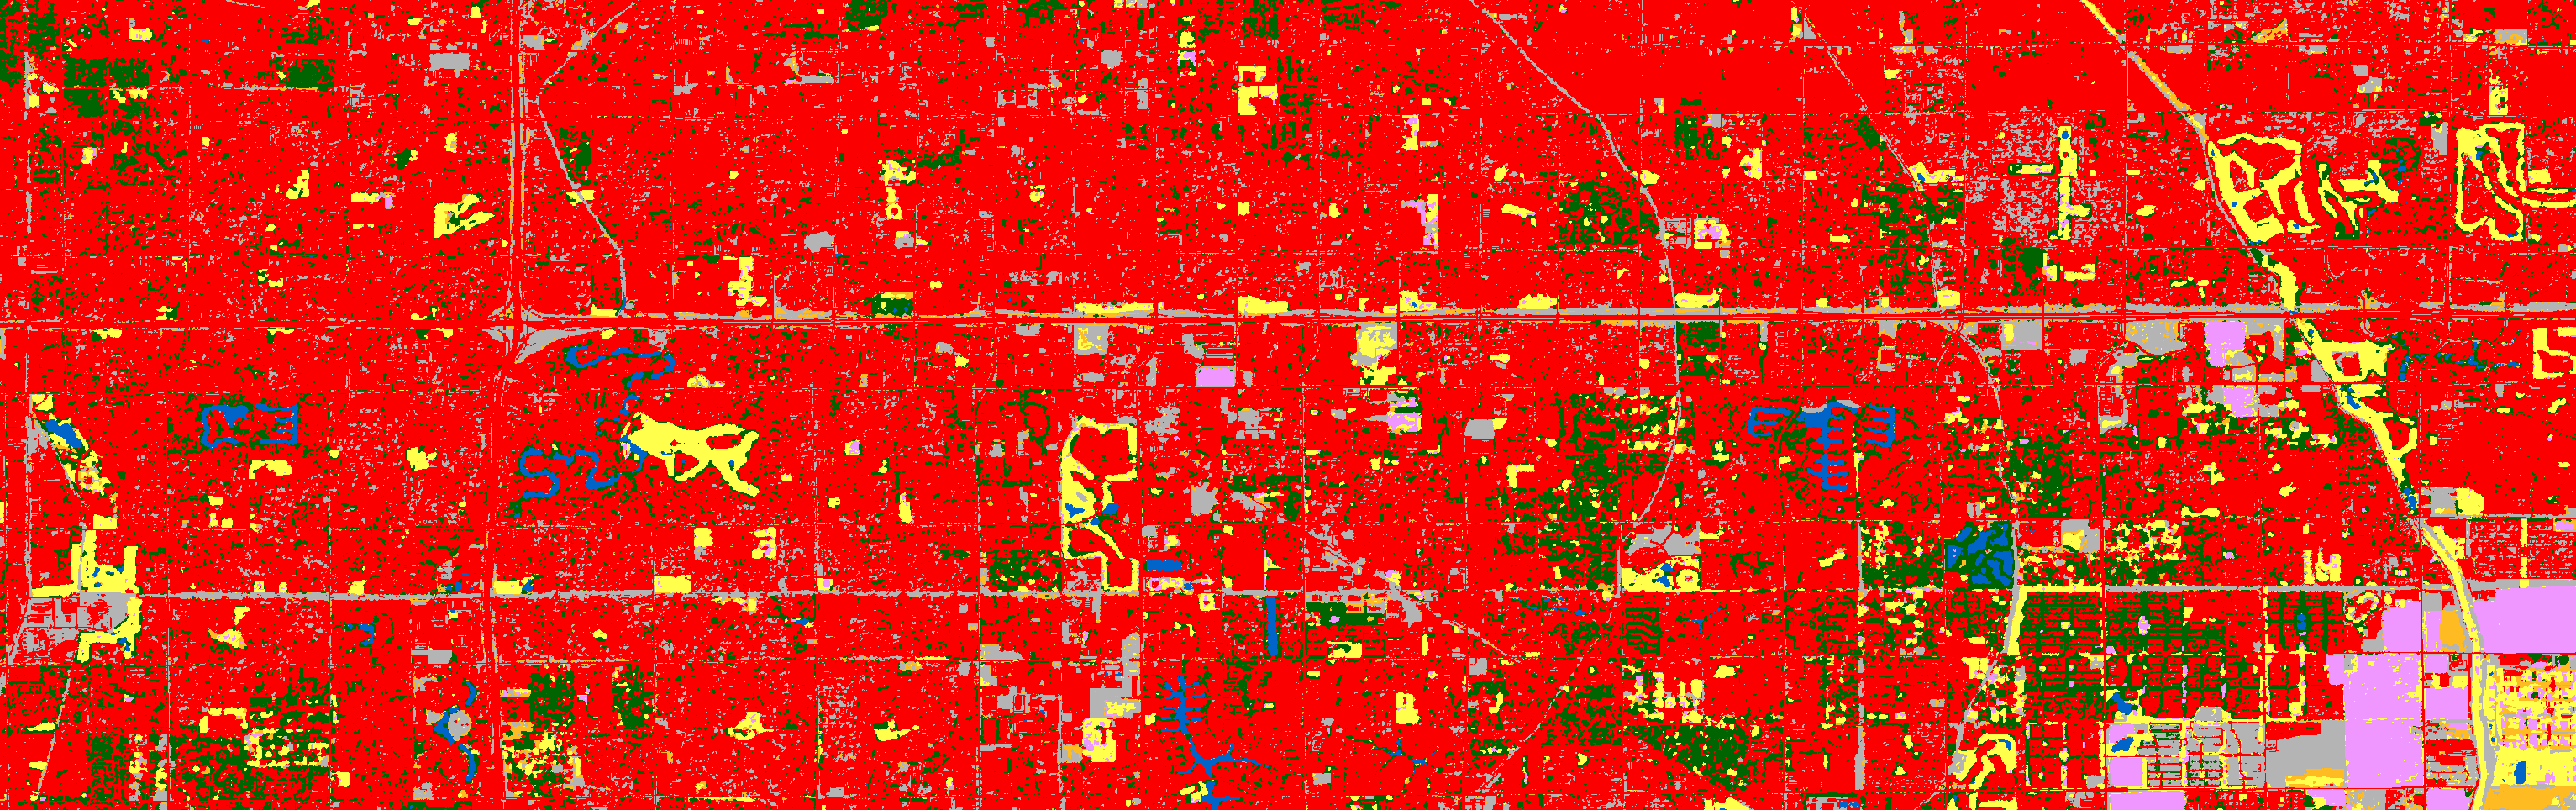

In [7]:
image

### Analysis

![Screenshot%202024-03-26%20at%208.15.20%E2%80%AFPM.png](attachment:Screenshot%202024-03-26%20at%208.15.20%E2%80%AFPM.png)

In [8]:
image_tf.shape

TensorShape([964, 3066])

In [9]:
tensor_flattened = tf.reshape(image_tf, [-1])
pixel_count=tensor_flattened.shape
pixel_count

TensorShape([2955624])

In [10]:
count_60 = tf.reduce_sum(tf.cast(tf.equal(image_tf, 60), tf.int32)).numpy()
count_30 = tf.reduce_sum(tf.cast(tf.equal(image_tf, 30), tf.int32)).numpy()
count_20 = tf.reduce_sum(tf.cast(tf.equal(image_tf, 20), tf.int32)).numpy()
vacant_count=count_60+count_20+count_30
print("Vacant pixels:",vacant_count)
print("Ratio of vacant to total:", vacant_count/pixel_count)

Vacant pixels: 440816
Ratio of vacant to total: [0.14914482]


In [11]:
unique_values, _ = tf.unique(tensor_flattened)

number_of_unique_values = tf.shape(unique_values)[0]

print(number_of_unique_values.numpy())
print("Unique values:", unique_values.numpy())

7
Unique values: [10 50 60 20 30 40 80]


### Creating vacant land binary mask

In [12]:
vacant = tf.where((image_tf == 20) | (image_tf == 30) | (image_tf == 60), 1, 0)

print(vacant)

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]], shape=(964, 3066), dtype=int32)


In [13]:
count_ones = tf.reduce_sum(vacant)
print("Count of number of ones:", count_ones.numpy())

Count of number of ones: 440816


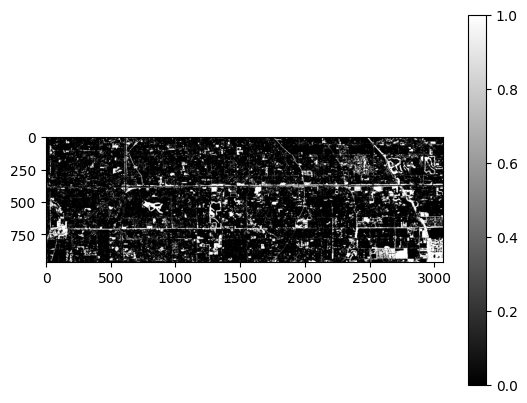

(964, 3066)


In [14]:
vacant_np = vacant.numpy()

plt.imshow(vacant_np, cmap='gray')  
plt.colorbar()  
plt.show()
print(vacant.shape)

### Preprocessing

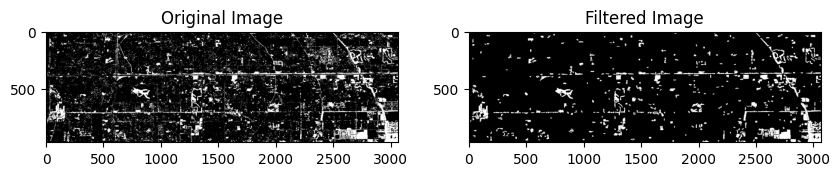

In [15]:
tensor_data=vacant
img_data = tensor_data.numpy()


img = img_data.astype(np.uint8) * 255


kernel_size = (5, 5) 


kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
eroded_img = cv2.erode(img, kernel, iterations=1)

dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

min_area = 100 
nb_components, output, stats, _ = cv2.connectedComponentsWithStats(dilated_img, connectivity=8)
sizes = stats[1:, -1]
nb_components = nb_components - 1

filtered_img = np.zeros_like(dilated_img)
for i in range(0, nb_components):
    if sizes[i] >= min_area:
        filtered_img[output == i + 1] = 255


filtered_tensor = torch.from_numpy(filtered_img / 255).int()




plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(tensor_data, cmap='gray')
plt.title('Original Image')


plt.subplot(1, 2, 2)
plt.imshow(filtered_tensor, cmap='gray')
plt.title('Filtered Image')

plt.show()

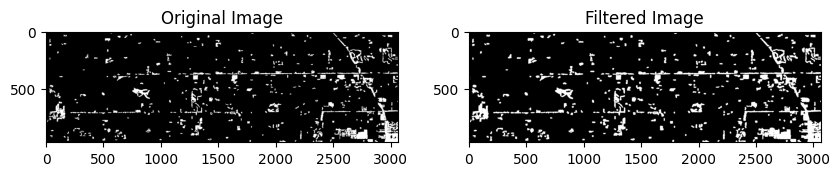

In [16]:
filtered_img_er = 1 - filtered_tensor.numpy()
filtered_255 = filtered_img_er.astype(np.uint8) * 255
kernel_size = (5, 5)  

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
eroded_img2 = cv2.erode(filtered_255, kernel, iterations=1)
processed_vacant_1 = torch.from_numpy(eroded_img2 / 255).int()
processed_vacant=1-processed_vacant_1
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(filtered_tensor, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(processed_vacant, cmap='gray')
plt.title('Filtered Image')

plt.show()

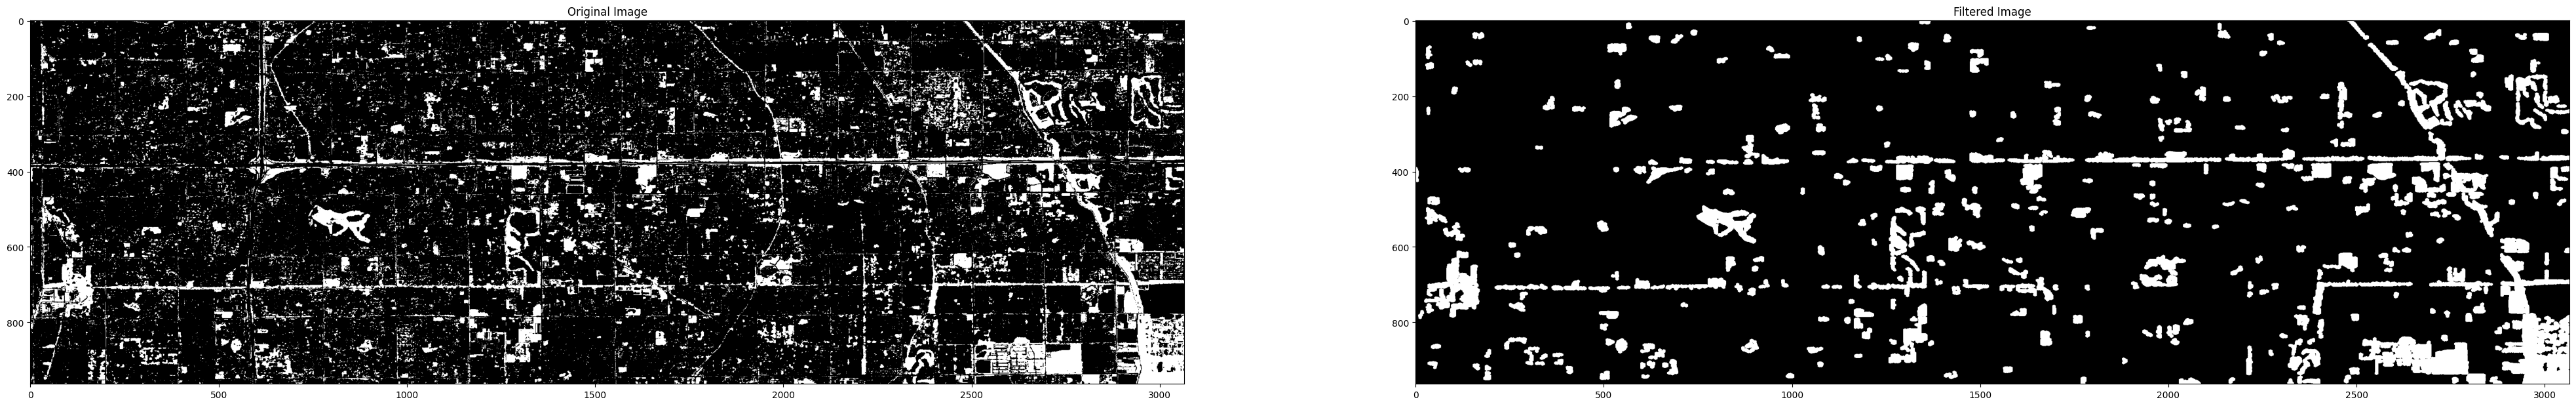

In [17]:
plt.figure(figsize=(50, 50))
plt.subplot(1, 2, 1)
plt.imshow(vacant, cmap='gray')
plt.title('Original Image')


plt.subplot(1, 2, 2)
plt.imshow(processed_vacant, cmap='gray')
plt.title('Filtered Image')

plt.show()

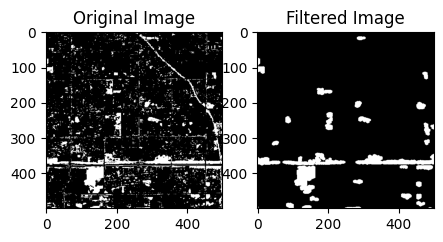

In [18]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(vacant[0:500,1500:2000], cmap='gray')
plt.title('Original Image')


plt.subplot(1, 2, 2)
plt.imshow(processed_vacant[0:500,1500:2000], cmap='gray')
plt.title('Filtered Image')

plt.show()

In [19]:
lst=Image.open('/content/Landsat9_ST_B10 copy.tif')

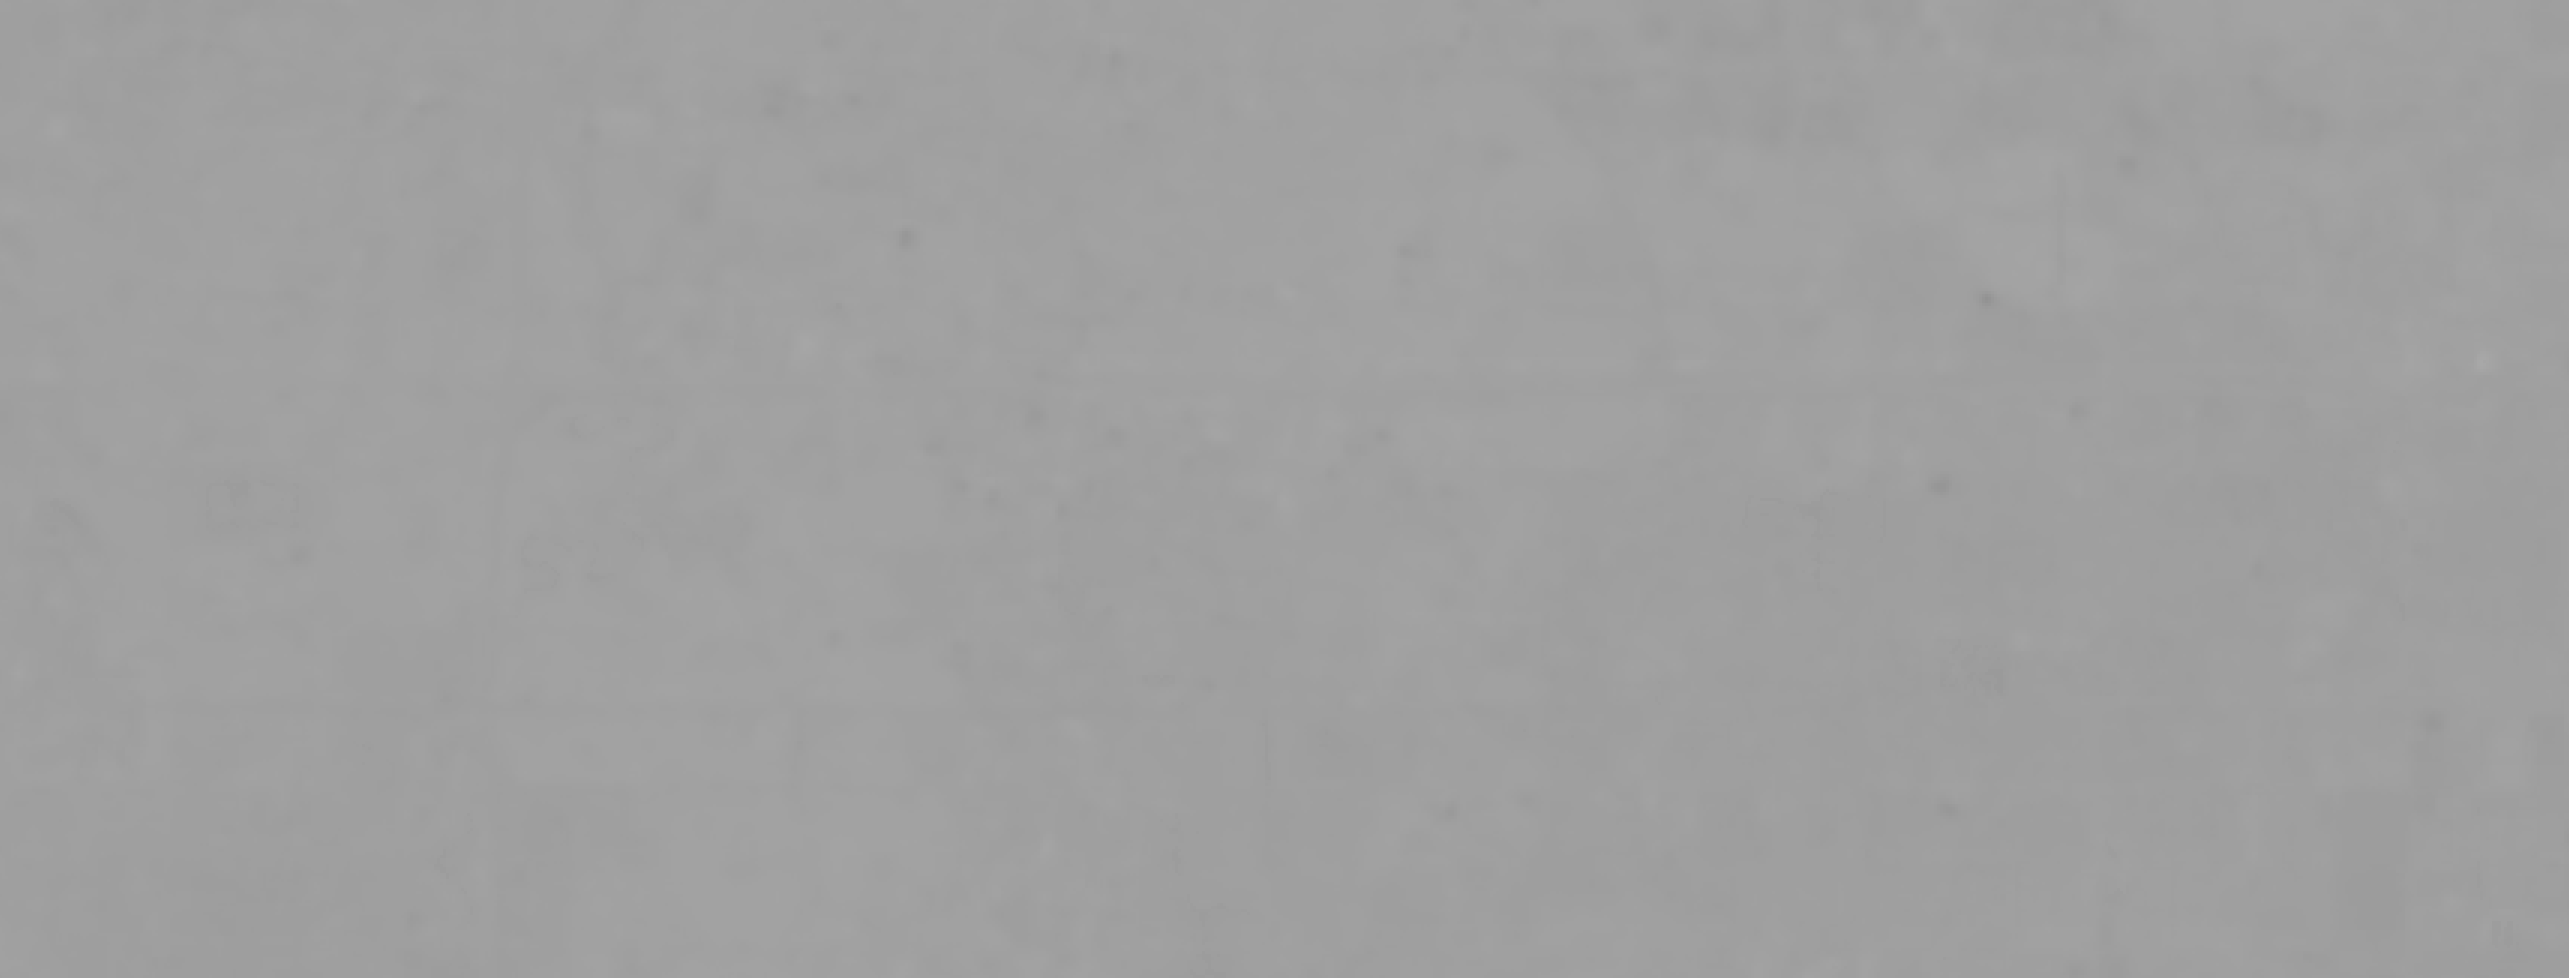

In [20]:
lst

In [21]:
lst_tf=tf.constant(lst)

In [22]:
lst_tf

<tf.Tensor: shape=(978, 2569), dtype=uint16, numpy=
array([[41037, 41037, 41011, ..., 40824, 40828, 40828],
       [41037, 41037, 41011, ..., 40824, 40828, 40828],
       [41037, 41037, 41011, ..., 40824, 40828, 40828],
       ...,
       [40988, 40988, 41055, ..., 40523, 40510, 40510],
       [40988, 40988, 41055, ..., 40523, 40510, 40510],
       [40988, 40988, 41055, ..., 40523, 40510, 40510]], dtype=uint16)>

In [23]:
image_tensor = lst_tf

image_tensor_float = tf.cast(image_tensor, tf.float32)

temperature_kelvin = (image_tensor_float * 0.00341802) + 149

temperature_celsius = temperature_kelvin - 273.15

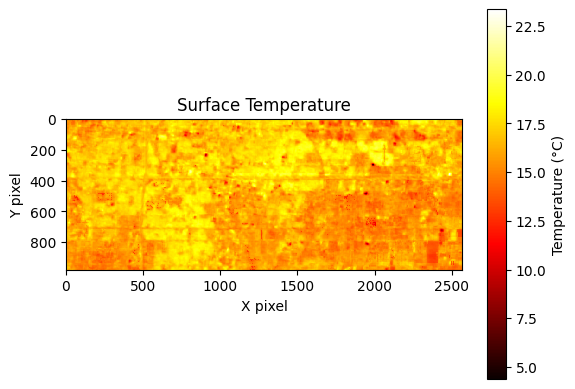

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf


temperature_numpy = temperature_celsius.numpy()

fig, ax = plt.subplots()

cax = ax.imshow(temperature_numpy, cmap='hot', interpolation='nearest')

fig.colorbar(cax, ax=ax, label='Temperature (°C)')

ax.set_title('Surface Temperature')
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')

plt.show()


torch.Size([964, 3066])

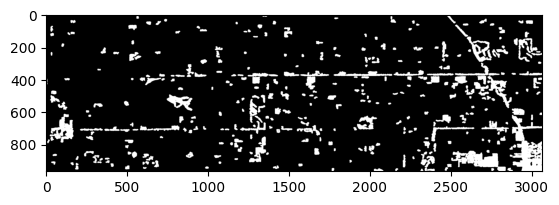

In [25]:
plt.imshow(processed_vacant, cmap='gray')
processed_vacant.shape

In [26]:
lst_tensor=temperature_celsius
lst_tensor_2d = tf.constant(lst_tensor)  


lst_tensor_3d = tf.expand_dims(lst_tensor_2d, axis=-1)

resized_lst_tensor_3d = tf.image.resize(
    lst_tensor_3d, [964, 3066], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
)

resized_lst_tensor_2d = tf.squeeze(resized_lst_tensor_3d, axis=-1)

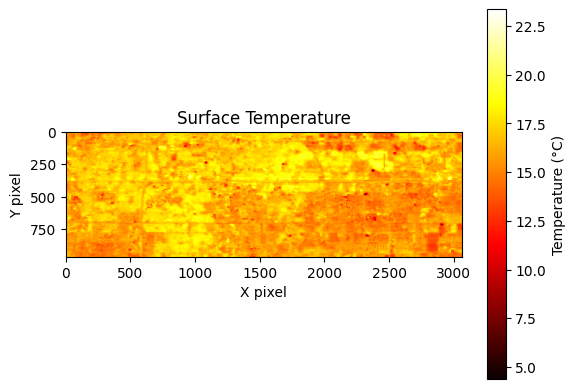

In [27]:
resized_lst_tensor_2d_numpy = resized_lst_tensor_2d.numpy()

fig, ax = plt.subplots()


cax = ax.imshow(resized_lst_tensor_2d_numpy, cmap='hot', interpolation='nearest')

fig.colorbar(cax, ax=ax, label='Temperature (°C)')


ax.set_title('Surface Temperature')
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')


plt.show()


In [28]:
land_cover=processed_vacant
land_cover

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]], dtype=torch.int32)

In [29]:
temp_cover=torch.from_numpy(resized_lst_tensor_2d_numpy)

In [30]:
temp_cover

tensor([[16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        [16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        [16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        ...,
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140],
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140],
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140]])

In [31]:
land_cover.shape

torch.Size([964, 3066])

In [32]:
temp_cover.shape

torch.Size([964, 3066])

In [33]:
np.save('land_cover.npy', land_cover.numpy())
np.save('temp_cover.npy', temp_cover.numpy())

temp_cover

image_tf

In [34]:
lndcvr=torch.tensor(image_tf.numpy())

In [35]:
type(lndcvr)

torch.Tensor

In [36]:
type(temp_cover)

torch.Tensor

In [69]:
print(lndcvr)

tensor([[10, 10, 10,  ..., 50, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        ...,
        [50, 50, 50,  ..., 60, 60, 60],
        [50, 50, 50,  ..., 60, 60, 60],
        [50, 50, 50,  ..., 60, 60, 60]], dtype=torch.uint8)


In [71]:
print(lndcvr.shape)

torch.Size([964, 3066])


In [72]:
print(temp_cover)

tensor([[16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        [16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        [16.1153, 16.1153, 16.0264,  ..., 15.3872, 15.4009, 15.4009],
        ...,
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140],
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140],
        [15.9478, 15.9478, 16.1768,  ..., 14.3584, 14.3140, 14.3140]])


In [73]:
print(temp_cover.shape)

torch.Size([964, 3066])


In [86]:
import torch

land_cover = lndcvr

num_classes = torch.unique(land_cover).shape[0]

print(f"Number of Classes in Land Cover: {num_classes}")

unique_classes = torch.unique(land_cover)

print(f"Land Cover Classes: {', '.join(str(class_value.item()) for class_value in unique_classes)}")


Number of Classes in Land Cover: 7
Land Cover Classes: 10, 20, 30, 40, 50, 60, 80


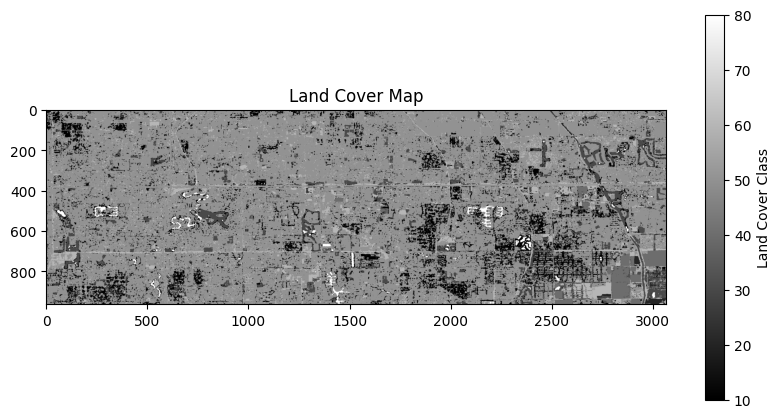

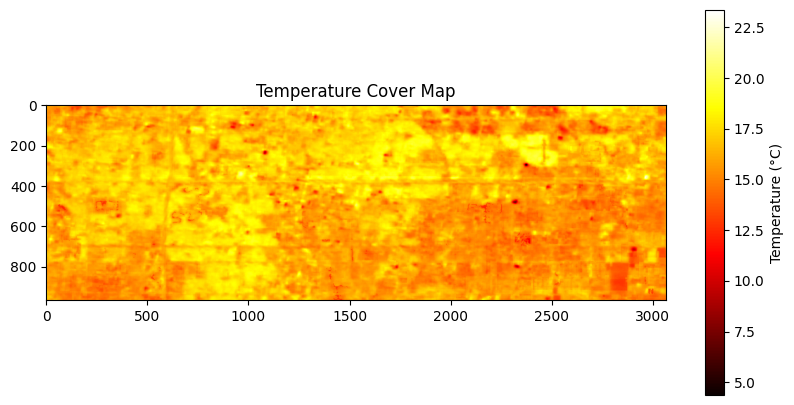

In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.imshow(lndcvr, cmap='gray')
plt.colorbar(label='Land Cover Class')
plt.title('Land Cover Map')
plt.show()


plt.figure(figsize=(10, 5))
plt.imshow(temp_cover, cmap='hot')
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Cover Map')
plt.show()


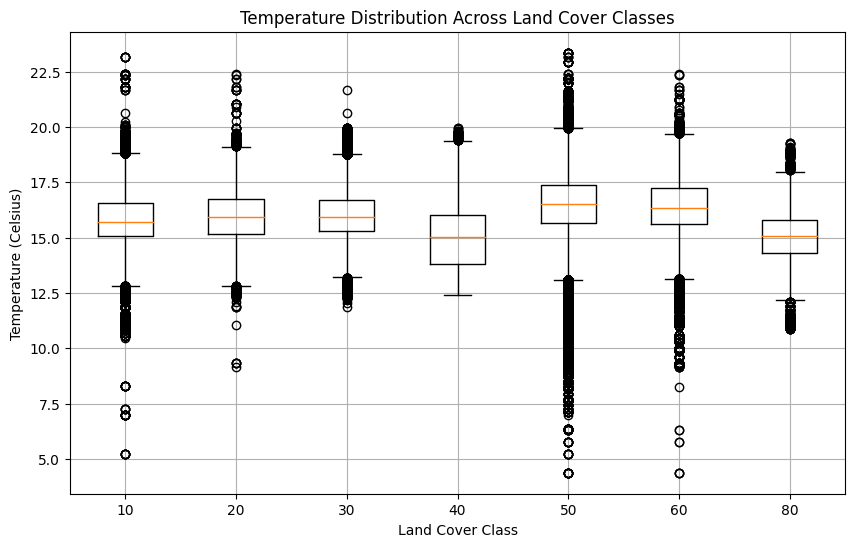

In [91]:
import numpy as np
import matplotlib.pyplot as plt

land_cover_values = [10, 20, 30, 40, 50, 60, 80]

land_cover_modified = np.copy(lndcvr)
temperature_modified = np.copy(temp_cover)

for i, class_value in enumerate(land_cover_values):
    land_cover_modified[lndcvr == i] = class_value

temperature_by_class = []

for class_value in land_cover_values:
    class_temperatures = temperature_modified[land_cover_modified == class_value]
    temperature_by_class.append(class_temperatures)

plt.figure(figsize=(10, 6))
plt.boxplot(temperature_by_class, labels=land_cover_values)
plt.xlabel('Land Cover Class')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature Distribution Across Land Cover Classes')
plt.grid(True)
plt.show()


tensor([15.8452, 15.9564, 16.0394, 15.0628, 16.5055, 16.4320, 14.9583])


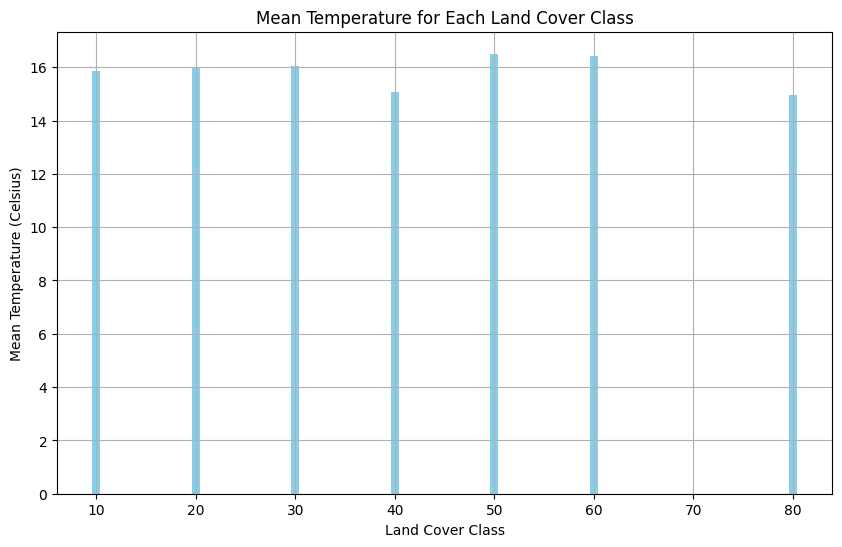

In [78]:
import torch
import matplotlib.pyplot as plt



unique_classes = torch.unique(lndcvr)

mean_temps = torch.zeros(len(unique_classes))


for i, class_value in enumerate(unique_classes):
  class_mask = lndcvr == class_value
  class_temps = temp_cover[class_mask]
  mean_class_temp = torch.mean(class_temps)
  mean_temps[i] = mean_class_temp
print(mean_temps)

plt.figure(figsize=(10, 6))
plt.bar(unique_classes.numpy(), mean_temps.numpy(), color='skyblue')
plt.xlabel('Land Cover Class')
plt.ylabel('Mean Temperature (Celsius)')
plt.title('Mean Temperature for Each Land Cover Class')
plt.grid(True)
plt.show()

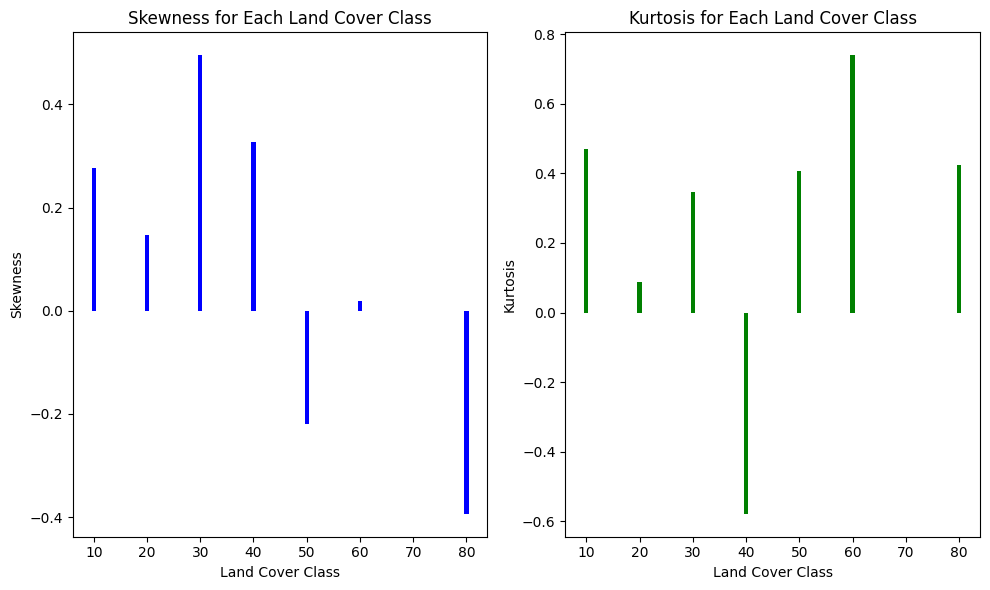

In [92]:
import numpy as np
import matplotlib.pyplot as plt

land_cover_values = [10, 20, 30, 40, 50, 60, 80]

land_cover_modified = np.copy(lndcvr)
temperature_modified = np.copy(temp_cover)

for i, class_value in enumerate(land_cover_values):
    land_cover_modified[lndcvr == i] = class_value

skewness_by_class = []
kurtosis_by_class = []

for class_value in land_cover_values:
    class_temperatures = temperature_modified[land_cover_modified == class_value]
    skewness = np.mean((class_temperatures - np.mean(class_temperatures))**3) / np.std(class_temperatures)**3
    kurtosis = np.mean((class_temperatures - np.mean(class_temperatures))**4) / np.std(class_temperatures)**4 - 3
    skewness_by_class.append(skewness)
    kurtosis_by_class.append(kurtosis)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.bar(land_cover_values, skewness_by_class, color='blue')
plt.xlabel('Land Cover Class')
plt.ylabel('Skewness')
plt.title('Skewness for Each Land Cover Class')

plt.subplot(1, 2, 2)
plt.bar(land_cover_values, kurtosis_by_class, color='green')
plt.xlabel('Land Cover Class')
plt.ylabel('Kurtosis')
plt.title('Kurtosis for Each Land Cover Class')

plt.tight_layout()
plt.show()



1. **Skewness**:
   - Skewness measures the asymmetry of the distribution of temperature values within each land cover class.
   - A positive skewness indicates that the distribution of temperature values is skewed to the right within a land cover class, meaning there are more high-temperature outliers.
   - A negative skewness indicates that the distribution of temperature values is skewed to the left within a land cover class, meaning there are more low-temperature outliers.
   - A skewness close to zero suggests that the distribution of temperature values is approximately symmetrical within a land cover class.

2. **Kurtosis**:
   - Kurtosis measures the tailedness or peakedness of the distribution of temperature values within each land cover class.
   - A positive kurtosis (or excess kurtosis) indicates that the distribution of temperature values has heavier tails and a sharper peak compared to a normal distribution. This suggests that there are more extreme temperature values (both high and low) within a land cover class.
   - A negative kurtosis (or excess kurtosis) indicates that the distribution of temperature values has lighter tails and a flatter peak compared to a normal distribution. This suggests that there are fewer extreme temperature values within a land cover class.
   - A kurtosis close to 3 (or excess kurtosis close to zero) indicates that the distribution of temperature values has similar tail behavior and peakedness as a normal distribution within a land cover class.


***#Season and Year wise analysis for land_cover/temperature_cover#***